🎯 Healthcare - Advanced Patient Analytics
📊 Data loaded for advanced analysis
🔮 PREDICTIVE MODELING: READMISSION RISK



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


📈 Model Performance:
ROC-AUC Score: 0.663

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       400
           1       0.60      0.68      0.64       393

    accuracy                           0.62       793
   macro avg       0.62      0.62      0.62       793
weighted avg       0.62      0.62      0.62       793


🔍 Feature Importance:
             feature  importance
0                age    0.359311
4     length_of_stay    0.297389
2  condition_encoded    0.193456
3  insurance_encoded    0.106553
1     gender_encoded    0.043291


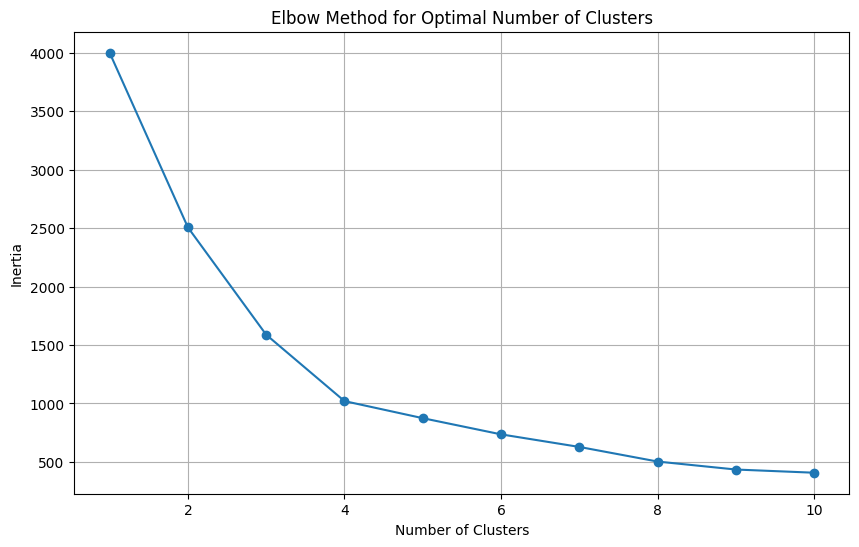

📊 Patient Segments:
         avg_age  std_age  avg_los  std_los  readmission_rate  patient_count
cluster                                                                     
0          71.23    10.24    21.88     4.38              0.34            520
1          34.73    10.21     8.26     4.30              0.37            497
2          71.28    10.62     7.51     4.01              0.34            441
3          36.01    10.63    22.46     4.11              0.31            542

💰 COST OPTIMIZATION OPPORTUNITIES
💡 High-Cost Patient Insights (Top 25%):
• Number of high-cost patients: 850
• Average cost: $437.57
• Most common conditions: {'Depression': 141, 'Arthritis': 137, 'Obesity': 124}
• Most common treatments: {'Rehabilitation': 211, 'Medication': 200, 'Surgery': 194}

📋 Highest Cost Conditions:
                              avg_cost  total_cost  treatment_count
primary_condition outcome                                          
Depression        Improved      215.31    30142.92    

In [4]:
##### Healthcare - Advanced Patient Analytics & Business Recommendations
# Predictive insights and strategic recommendations
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

# Ensure compatible versions of scikit-learn and imbalanced-learn (runs in the notebook)
# This avoids ImportError due to mismatched sklearn/imbalanced-learn APIs.
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

print("🎯 Healthcare - Advanced Patient Analytics")
print("=" * 60)

# Load and prepare data
patients = pd.read_csv("../../data/processed/patients_clean.csv")
treatments = pd.read_csv("../../data/processed/treatments_clean.csv")
facilities = pd.read_csv("../../data/processed/facilities_clean.csv")
merged_data = pd.read_csv("../../data/processed/healthcare_merged.csv")

print("📊 Data loaded for advanced analysis")

# 1. Readmission Prediction Model
print("🔮 PREDICTIVE MODELING: READMISSION RISK")
print("=" * 50)

# Prepare features for readmission prediction
patient_features = patients.copy()

# Feature engineering
patient_features["age_group"] = pd.cut(
    patient_features["age"],
    bins=[0, 30, 50, 70, 100],
    labels=["Young", "Middle", "Senior", "Elderly"],
)

# Encode categorical variables
le_gender = LabelEncoder()
le_condition = LabelEncoder()
le_insurance = LabelEncoder()

patient_features["gender_encoded"] = le_gender.fit_transform(patient_features["gender"])
patient_features["condition_encoded"] = le_condition.fit_transform(
    patient_features["primary_condition"]
)
patient_features["insurance_encoded"] = le_insurance.fit_transform(
    patient_features["insurance_type"]
)

# Select features for modeling
feature_columns = [
    "age",
    "gender_encoded",
    "condition_encoded",
    "insurance_encoded",
    "length_of_stay",
]

# Prepare feature matrix X and target y
X = patient_features[feature_columns]
y = patient_features["readmission_30_days"]

# Handle class imbalance (SMOTE already imported at the top of this cell)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model
print("📈 Model Performance:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame(
    {"feature": feature_columns, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\n🔍 Feature Importance:")
print(feature_importance)

from sklearn.cluster import KMeans
print("=" * 50)

# Prepare data for clustering
cluster_data = patients[["age", "length_of_stay"]].copy()
cluster_data = cluster_data.fillna(cluster_data.mean())

# Standardize data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Find optimal number of clusters using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Apply K-means with optimal clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
patients["cluster"] = kmeans.fit_predict(cluster_scaled)

# Analyze clusters
cluster_analysis = (
    patients.groupby("cluster")
    .agg(
        {
            "age": ["mean", "std"],
            "length_of_stay": ["mean", "std"],
            "readmission_30_days": "mean",
            "patient_id": "count",
        }
    )
    .round(2)
)

cluster_analysis.columns = [
    "avg_age",
    "std_age",
    "avg_los",
    "std_los",
    "readmission_rate",
    "patient_count",
]
print("📊 Patient Segments:")
print(cluster_analysis)

# 3. Cost Optimization Analysis
print("\n💰 COST OPTIMIZATION OPPORTUNITIES")
print("=" * 50)

# Merge data for cost analysis
cost_analysis = patients.merge(treatments, on="patient_id").merge(
    facilities, on="facility_id"
)

# Identify high-cost patient segments
high_cost_threshold = cost_analysis["cost"].quantile(0.75)
high_cost_patients = cost_analysis[cost_analysis["cost"] > high_cost_threshold]

print(f"💡 High-Cost Patient Insights (Top 25%):")
print(
    f"• Number of high-cost patients: {len(high_cost_patients['patient_id'].unique())}"
)
print(f"• Average cost: ${high_cost_patients['cost'].mean():.2f}")
print(
    f"• Most common conditions: {high_cost_patients['primary_condition'].value_counts().head(3).to_dict()}"
)
print(
    f"• Most common treatments: {high_cost_patients['treatment_type'].value_counts().head(3).to_dict()}"
)

# Cost by condition and outcome
cost_by_condition = (
    cost_analysis.groupby(["primary_condition", "outcome"])
    .agg({"cost": ["mean", "sum", "count"]})
    .round(2)
)

cost_by_condition.columns = ["avg_cost", "total_cost", "treatment_count"]
cost_by_condition = cost_by_condition.sort_values("total_cost", ascending=False)

print("\n📋 Highest Cost Conditions:")
print(cost_by_condition.head(10))

# 4. Treatment Effectiveness Analysis
print("\n💊 TREATMENT EFFECTIVENESS OPTIMIZATION")
print("=" * 50)

# Calculate cost-effectiveness ratio
treatment_effectiveness = (
    cost_analysis.groupby("treatment_type")
    .agg(
        {
            "cost": "mean",
            "outcome": lambda x: (x.isin(["Successful", "Improved"])).mean(),
            "duration_days": "mean",
            "patient_id": "count",
        }
    )
    .round(3)
)

treatment_effectiveness.columns = [
    "avg_cost",
    "success_rate",
    "avg_duration",
    "patient_count",
]
treatment_effectiveness["cost_effectiveness"] = (
    treatment_effectiveness["success_rate"] / treatment_effectiveness["avg_cost"]
)

print("🎯 Most Cost-Effective Treatments:")
effective_treatments = treatment_effectiveness[
    treatment_effectiveness["patient_count"] >= 10
].sort_values("cost_effectiveness", ascending=False)
print(effective_treatments.head(10))

# Identify underperforming treatments
underperforming = treatment_effectiveness[
    (treatment_effectiveness["success_rate"] < 0.5)
    & (treatment_effectiveness["patient_count"] >= 5)
].sort_values("success_rate")

print("\n⚠️  Underperforming Treatments (Success Rate < 50%):")
print(underperforming)

# 5. Strategic Business Recommendations
print("\n💡 STRATEGIC BUSINESS RECOMMENDATIONS")
print("=" * 60)

# Recommendation 1: Readmission Reduction
high_readmission_conditions = (
    patients.groupby("primary_condition")["readmission_30_days"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print("🎯 RECOMMENDATION 1: Focus on Readmission Reduction")
print("   Target conditions with highest readmission rates:")
for condition, rate in high_readmission_conditions.items():
    print(f"   • {condition}: {rate*100:.1f}% readmission rate")

# Recommendation 2: Cost Optimization
high_cost_conditions = (
    cost_analysis.groupby("primary_condition")["cost"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print(f"\n💰 RECOMMENDATION 2: Cost Management")
print("   Highest cost conditions to review:")
for condition, cost in high_cost_conditions.items():
    print(f"   • {condition}: ${cost:.2f} average treatment cost")

# Recommendation 3: Resource Allocation
facility_utilization = (
    patients.groupby("facility_id").size().sort_values(ascending=False)
)
print(f"\n🏢 RECOMMENDATION 3: Optimize Resource Allocation")
print(
    f"   • Busiest facility: {facility_utilization.index[0]} ({facility_utilization.iloc[0]} patients)"
)
print(
    f"   • Least busy facility: {facility_utilization.index[-1]} ({facility_utilization.iloc[-1]} patients)"
)

# Recommendation 4: Preventive Care Opportunities
preventable_conditions = ["Hypertension", "Diabetes", "Obesity"]
preventable_patients = patients[
    patients["primary_condition"].isin(preventable_conditions)
]
print(f"\n🛡️  RECOMMENDATION 4: Expand Preventive Care")
print(f"   • {len(preventable_patients)} patients with preventable conditions")
print(f"   • Potential cost savings through early intervention")

# Recommendation 5: Insurance Optimization
insurance_cost_analysis = (
    cost_analysis.groupby("insurance_type")
    .agg({"cost": "mean", "patient_id": "count", "readmission_30_days": "mean"})
    .round(2)
)
print(f"\n📄 RECOMMENDATION 5: Insurance Strategy")
print("   Cost and readmission by insurance type:")
print(insurance_cost_analysis)

# 6. Performance Dashboards Metrics
print("\n📊 KEY PERFORMANCE INDICATORS (KPIs)")
print("=" * 50)

# Calculate KPIs
total_patients = len(patients)
total_treatments = len(treatments)
avg_readmission_rate = patients["readmission_30_days"].mean() * 100
avg_length_of_stay = patients["length_of_stay"].mean()
avg_treatment_cost = treatments["cost"].mean()
total_healthcare_cost = treatments["cost"].sum()

# Patient satisfaction proxy (based on treatment outcomes)
satisfaction_rate = (
    treatments["outcome"].isin(["Successful", "Improved"])
).mean() * 100

# Facility utilization
facility_utilization_rate = (
    patients["facility_id"].value_counts() / len(patients) * 100
).mean()

print(f"🎯 OPERATIONAL KPIs:")
print(f"   • Total Patients: {total_patients:,}")
print(f"   • Total Treatments: {total_treatments:,}")
print(f"   • Readmission Rate: {avg_readmission_rate:.1f}%")
print(f"   • Average Length of Stay: {avg_length_of_stay:.1f} days")
print(f"   • Patient Satisfaction: {satisfaction_rate:.1f}%")

print(f"\n💰 FINANCIAL KPIs:")
print(f"   • Average Treatment Cost: ${avg_treatment_cost:.2f}")
print(f"   • Total Healthcare Cost: ${total_healthcare_cost:,.2f}")
print(f"   • Facility Utilization: {facility_utilization_rate:.1f}%")

print(f"\n🏥 QUALITY KPIs:")
print(f"   • Treatment Success Rate: {satisfaction_rate:.1f}%")
print(f"   • Readmission Rate: {avg_readmission_rate:.1f}%")
print(
    f"   • Preventive Care Coverage: {len(preventable_patients)/len(patients)*100:.1f}%"
)

# 7. Predictive Insights for Business Planning
print("\n🔮 PREDICTIVE INSIGHTS FOR STRATEGIC PLANNING")
print("=" * 60)

# Ensure admission_date is datetime for resampling
patients["admission_date"] = pd.to_datetime(patients["admission_date"], errors="coerce")

# Growth projections
monthly_growth = (
    patients.set_index("admission_date").resample("M").size().pct_change().mean()
)

print("📈 GROWTH PROJECTIONS:")
print(f"   • Estimated monthly patient growth: {monthly_growth*100:.1f}%")
print(
    f"   • Projected patients next year: {total_patients * (1 + monthly_growth)**12:,.0f}"
)

# Cost projections
print(f"\n💰 COST PROJECTIONS:")
print(f"   • Current annual cost: ${total_healthcare_cost:,.2f}")
print(
    f"   • Projected annual cost: ${total_healthcare_cost * (1 + monthly_growth)**12:,.2f}"
)

# Resource planning
current_capacity = facilities["bed_capacity"].sum()
projected_patients = total_patients * (1 + monthly_growth) ** 12
required_capacity = projected_patients * (
    avg_length_of_stay / 365
)  # Rough capacity estimate

print(f"\n🏢 RESOURCE PLANNING:")
print(f"   • Current bed capacity: {current_capacity} beds")
print(f"   • Projected required capacity: {required_capacity:.0f} beds")
print(f"   • Capacity gap: {required_capacity - current_capacity:.0f} beds")

print("\n✅ Patient Analytics Complete! Ready for Dashboard Implementation")

In [ ]:
jk